In [1]:
from scipy.io import loadmat
import os
import random
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from tqdm import tqdm
import torch.optim as optim
import yaml
import pickle
from torch.utils.data import Dataset, DataLoader
import pdb

# Data description:
______

|Variable Name | Type | Size | Description|
|----|----|----|----|
| tra_X_te | array of matrices | 1*840 | test set input data: traffic indices for 840 contiguous quarter-hours each element is a 36*48 matrix: 36 spatial locations by 48 features|
| tra_X_tr | array of matrices | 1*1261 | training set input data: traffic indices for 1261 contiouous quarter-hours each element is a 36*48 matrix: 36 spatial locations by 48 features|
| tra_Y_te | array of matrices | 36*840 | test set output data: traffic flow for 36 locations in 840 contiguous quarter-hours from 2017-01-02 00:00 |
| tra_Y_tr | array of matrices | 36*1261 | training set output data: traffic flow for 36 locations in 1261 contiouous quarter-hours until 2017-02-01 00:15 |
| tra_adj_mat | squared matrix | 36*36 | adjacency matrix denoting the spatial connectivity of traffic network among 36 locations|
| tra_X_te | array of matrices | 1*840 | test set input data: traffic indices for 840 contiguous quarter-hours each element is a 36*48 matrix: 36 spatial locations by 48 features|


In [2]:
# Loading the configuration file 
with open("./config-traffic.yaml", 'r') as f:
    config = yaml.safe_load(f)
    
# Loading the dataset
mat_data = loadmat('../data/traffic_dataset.mat')
adj_matrix = mat_data['tra_adj_mat']

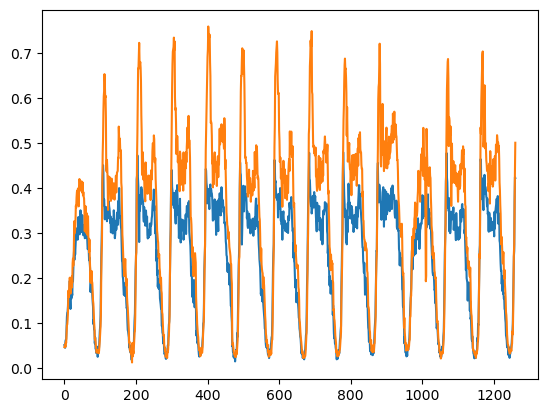

In [3]:
plt.plot(mat_data['tra_Y_tr'][0])
plt.plot(mat_data['tra_Y_tr'][1])

plt.show()

In [4]:
class traffic_dataset(Dataset):
    
    def __init__(self, 
                 data,
                 past_step:int, 
                 future_step:int,
                 adj):
        """
        Arguments:
            data: is a 36 x len() it represent the time series for each node
            past_step (int): previous step to look back
            future_step (int): future step to look for
        """
        self.x = []
        self.y = []
        self.adj = adj
        for i in range(past_step,  data.shape[1]-future_step):
            self.x.append(data[:,i-past_step:i])
            self.y.append(data[:,i:i+future_step])
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx], self.adj


In [5]:
past_step = 10
future_step = 4
batch_size = 128
train_dataset = traffic_dataset(mat_data['tra_Y_tr'], 
                                past_step = past_step, 
                                future_step = future_step,
                                adj = adj_matrix)
val_dataset = traffic_dataset(mat_data['tra_Y_te'], 
                                past_step = past_step, 
                                future_step = future_step,
                                adj = adj_matrix)
dl_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dl_val = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
batch, y, adj = next(iter(dl_train))

# Model
In this part it is reported the GCNN for this particular dataset

In [6]:
class my_gcnn(torch.nn.Module):

    def __init__(self, 
                 in_channels: int, 
                 out_channels: int,
                 past:int, 
                 relu: bool = True):
        super(my_gcnn, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.past = past 
        self.lin = nn.Linear(in_channels, 
                             out_channels, 
                             bias = False)
        self.emb = nn.Linear(in_channels, 
                             256, 
                             bias = False)
        self.relu = nn.ReLU()
        if relu:
            self.act = nn.ReLU()
        else:
            self.act = nn.Identity()
        

    def forward(self,
                x0: tuple) -> torch.tensor:
        
        x, A = x0   
        x_emb = self.emb(x)
        pi = torch.einsum('bdjk,bdik->bdij', x_emb, x_emb)
        # Define the value you want to fill in the masked positions
        fill_value = -float('infinity')
        # Apply the mask to fill values in the input tensor
        pi = F.softmax(pi.masked_fill(A.unsqueeze(1).repeat(1,pi.shape[1],1,1) == 0., fill_value), -1)

        x = torch.einsum('bpik,bpkj->bpij', pi, x)
        x = self.lin(x)
        x = self.act(x)
        
        return (x, A)

class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTMCell, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size

        # LSTM weights and biases
        self.W_i = nn.Linear(input_size + hidden_size, hidden_size)
        self.W_f = nn.Linear(input_size + hidden_size, hidden_size)
        self.W_o = nn.Linear(input_size + hidden_size, hidden_size)
        self.W_g = nn.Linear(input_size + hidden_size, hidden_size)

    def forward(self, x, hidden):
        h_prev, c_prev = hidden
        
        # Concatenate input and previous hidden state
        combined = torch.cat((x, h_prev), dim=-1)

        # Compute the input, forget, output, and cell gates
        i = torch.sigmoid(self.W_i(combined))
        f = torch.sigmoid(self.W_f(combined))
        o = torch.sigmoid(self.W_o(combined))
        g = torch.tanh(self.W_g(combined))

        # Update the cell state and hidden state
        c = f * c_prev + i * g
        h = o * torch.tanh(c)

        return h, c
        
        
class GLSTM(torch.nn.Module):
    def __init__(self, 
                 past: int, 
                 future: int,
                 num_layer_gnn:int = 1,
                 hidden_gnn:int = 64,
                 hidden_lstm: int = 128, 
                 hidden_propagation:int = 256):
        
        super(GLSTM, self).__init__()
        
        self.out_gnn = 1 #nfeat_out_gnn        
        self.past = past 
        self.future = future
        self.hidden_gnn = hidden_gnn
        self.hidden_lstm = hidden_lstm
        
        ########## FIRST GNN PART #############
        # LA CGNN mi permette di vedere spazialmente la situazione circostante
        # più layer di CGNN più spazialmente distante arriva l'informazione
        # B x P x N x F
    
        layers = []
        
        for i in range(num_layer_gnn):
            in_channels = 1 if i == 0 else hidden_gnn
            #out_channels = self.out_gnn if i == (num_layer_gnn - 1) else hidden_gnn
            #relu = True if i != (num_layer_gnn - 1) else False
            layers.append(my_gcnn(in_channels = in_channels, 
                                  out_channels = hidden_gnn, 
                                  past = past,
                                  relu = True))            
        self.gnn = nn.Sequential(*layers)

        self.lstm = LSTMCell(input_size = hidden_gnn, 
                             hidden_size = hidden_lstm)
        
        self.decoding = nn.Sequential(nn.Linear(in_features = hidden_lstm, 
                                                out_features = hidden_propagation), 
                                      nn.Sigmoid(),
                                      nn.Linear(in_features = hidden_propagation,
                                                out_features = future_step))
               
    def forward(self, x, adj):
        # pre-processing dei dati
        nodes = x.shape[1]
        
        ########## GNN processing ######################
        x, _ = self.gnn((x.transpose(-2,-1).unsqueeze(-1).float(), adj.float()))

        batch_size, seq_len, nodes, features = x.size()
        # Initialize hidden and cell states
        h, c = [torch.zeros(batch_size, nodes, self.hidden_lstm).to(x.device)] * 2
        for t in range(seq_len):
            h, c = self.lstm(x[:, t], (h, c))
        x = self.decoding(h)
        return  x
        
model = GLSTM(past = past_step,
              future = future_step)
model(batch, adj).shape

torch.Size([128, 36, 4])

In [7]:
def step(model, 
         dataloader,
         optimizer,
         criterion,
         device,
         training: bool = False):

    if training:
        model.train()
    else:
        model.eval()
    desc = "training" if training else "validation"

    loss_epoch = 0.0
    
    for x, y, adj in iter(dataloader):
        yh = model(x.to(device).float(), adj.to(device))
        overall = criterion(yh.sum(-1).float(), y.sum(-1).to(device).float())
        loss = criterion(yh.float(), y.to(device).float()) + overall

        # Backward and optimize
        if training:
            loss.backward()
            optimizer.step()
            
            # blocking the gradient summation 
            optimizer.zero_grad()


        loss_epoch += loss.item()/len(dataloader)

    return loss_epoch


def training(model, 
             train_loader, 
             val_loader, 
             num_epochs, 
             criterion,
             device,
             optimizer):
    loss_train = []
    loss_val = []
    be = np.inf
    bm = model
    
    for epoch in tqdm(range(num_epochs)):
            
        # Calculate average loss for the epoch
        loss = step(model = model, 
                         dataloader = train_loader, 
                         optimizer = optimizer, 
                         device = device,
                         criterion = criterion,
                         training = True)
        
        loss_train.append(loss)
        
        loss = step(model = model, 
                         dataloader = val_loader, 
                         optimizer = optimizer, 
                         device = device,
                         criterion = criterion,
                         training = False)
        
        loss_val.append(loss)
        
        if (loss_val[-1]<be) & (epoch/num_epochs>0.15):
            be = loss_val[-1]
            bm = model
        if (epoch+1)%15 == 0:
            print(f"loss train epoch {epoch+1} == {loss_train[-1]}")
            print(f"loss val epoch {epoch+1} == {loss_val[-1]}")
    return bm, loss_train, loss_val



In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GLSTM(past = past_step,
              future = future_step).to(device)
optimizer = optim.Adam(model.parameters(), 
                       lr = 1e-3)

In [9]:
def linfty(y, yh):
    diff = torch.sum(torch.abs(y.to(device)-yh).max(0)[0])
    mse = F.mse_loss(y,yh)
    return diff + 10*mse
    

In [10]:
model, loss_training, loss_validation = training(model, 
                                                 train_loader = dl_train, 
                                                 val_loader = dl_val, 
                                                 num_epochs = 100, 
                                                 criterion = linfty, #nn.MSELoss(reduction="mean"),
                                                 optimizer = optimizer, 
                                                 device = device)

 15%|██████▎                                   | 15/100 [01:05<06:18,  4.45s/it]

loss train epoch 15 == 81.75446014404297
loss val epoch 15 == 84.55985913957869


 30%|████████████▌                             | 30/100 [02:13<05:15,  4.50s/it]

loss train epoch 30 == 80.67925949096679
loss val epoch 30 == 84.02940586635044


 45%|██████████████████▉                       | 45/100 [03:19<04:00,  4.37s/it]

loss train epoch 45 == 79.36298751831055
loss val epoch 45 == 83.07366180419922


 60%|█████████████████████████▏                | 60/100 [04:27<03:02,  4.55s/it]

loss train epoch 60 == 78.57347030639647
loss val epoch 60 == 82.1554423740932


 75%|███████████████████████████████▌          | 75/100 [05:34<01:52,  4.49s/it]

loss train epoch 75 == 79.68463897705078
loss val epoch 75 == 83.79222106933595


 90%|█████████████████████████████████████▊    | 90/100 [06:38<00:42,  4.22s/it]

loss train epoch 90 == 78.49486618041992
loss val epoch 90 == 82.06739698137555


100%|█████████████████████████████████████████| 100/100 [07:20<00:00,  4.41s/it]


In [19]:
def plot(model, 
         config,
         loss_training, 
         loss_validation, 
         name,
         dl_train = dl_train,
         dl_val = dl_val, 
         show = False):
    fig = px.line({"epochs": range(1,len(loss_training)+1), 
                                   "train": loss_training, 
                                   "validation": loss_validation}, 
                                  x = "epochs", 
                                  y = ["train", "validation"], 
                                  title= f"training loss for {name}")
    fig.add_vline(x = np.argsort(loss_validation)[0]+1)
    fig.add_hline(y = np.min(loss_validation))
    fig.write_html(os.path.join(config['paths']['fig'], f"loss_gnn_{name}.html"))
    if show:
        fig.show()
    
    nodes = 4
    yh_train = []
    y_train = []
    for x, y, adj in dl_train:
        out = model(x.float().to(device), adj.to(device))
        yh_train.append(np.concatenate(out.detach().cpu().numpy(),-1))
        y_train.append(np.concatenate(y.detach().cpu().numpy(),-1))
    yh_train = np.concatenate(yh_train, -1)
    y_train = np.concatenate(y_train, -1)
    
    yh_val = []
    y_val = []
    for x, y, adj in dl_val:
        out = model(x.float().to(device), adj.to(device))
        yh_val.append(np.concatenate(out.detach().cpu().numpy(),-1))
        y_val.append(np.concatenate(y.detach().cpu().numpy(),-1))
    yh_val = np.concatenate(yh_val, -1)
    y_val = np.concatenate(y_val, -1)

    b, n, f = y.shape
    # Stima 
    ### scelgo quali nodi plottare
    fig, ax = plt.subplots(nrows = f, 
                           ncols = 2, 
                           constrained_layout = True,
                           figsize = (20,10))
    
    print(f"rmse train {np.sqrt(np.mean((yh_train-y_train)**2))}")
    print(f"rmse validation {np.sqrt(np.mean((yh_val-y_val)**2))}")
    node = 3
    for i in range(f):
        ax[i,0].plot(yh_train[node, i::f][:400], label ="estimate")
        ax[i,0].plot(y_train[node, i::f][:400], label ="real")
        ax[i,1].plot(yh_val[node, i::f][:400], label ="estimate")
        ax[i,1].plot(y_val[node, i::f][:400], label ="real")
        
        ax[i, 0].legend()
        ax[i, 1].legend()
        
        ax[i, 0].title.set_text(f"step {i +1} train")
        ax[i, 1].title.set_text(f"step {i +1} validation")

    fig.suptitle(' Comparison between estimation and reality ', fontsize=20) 
    
    path = os.path.join(config['paths']['fig'], f"{name}.png")
    plt.savefig(path)
    if show:
        plt.show()
    plt.close(fig)
             


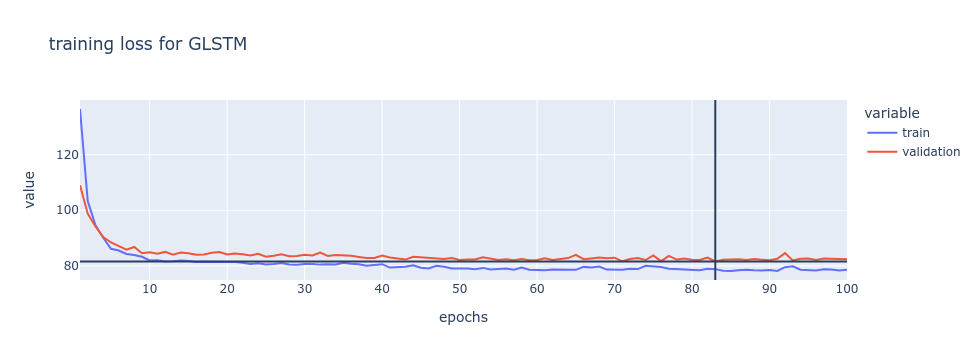

rmse train 0.1273644820588356
rmse validation 0.134028390049185


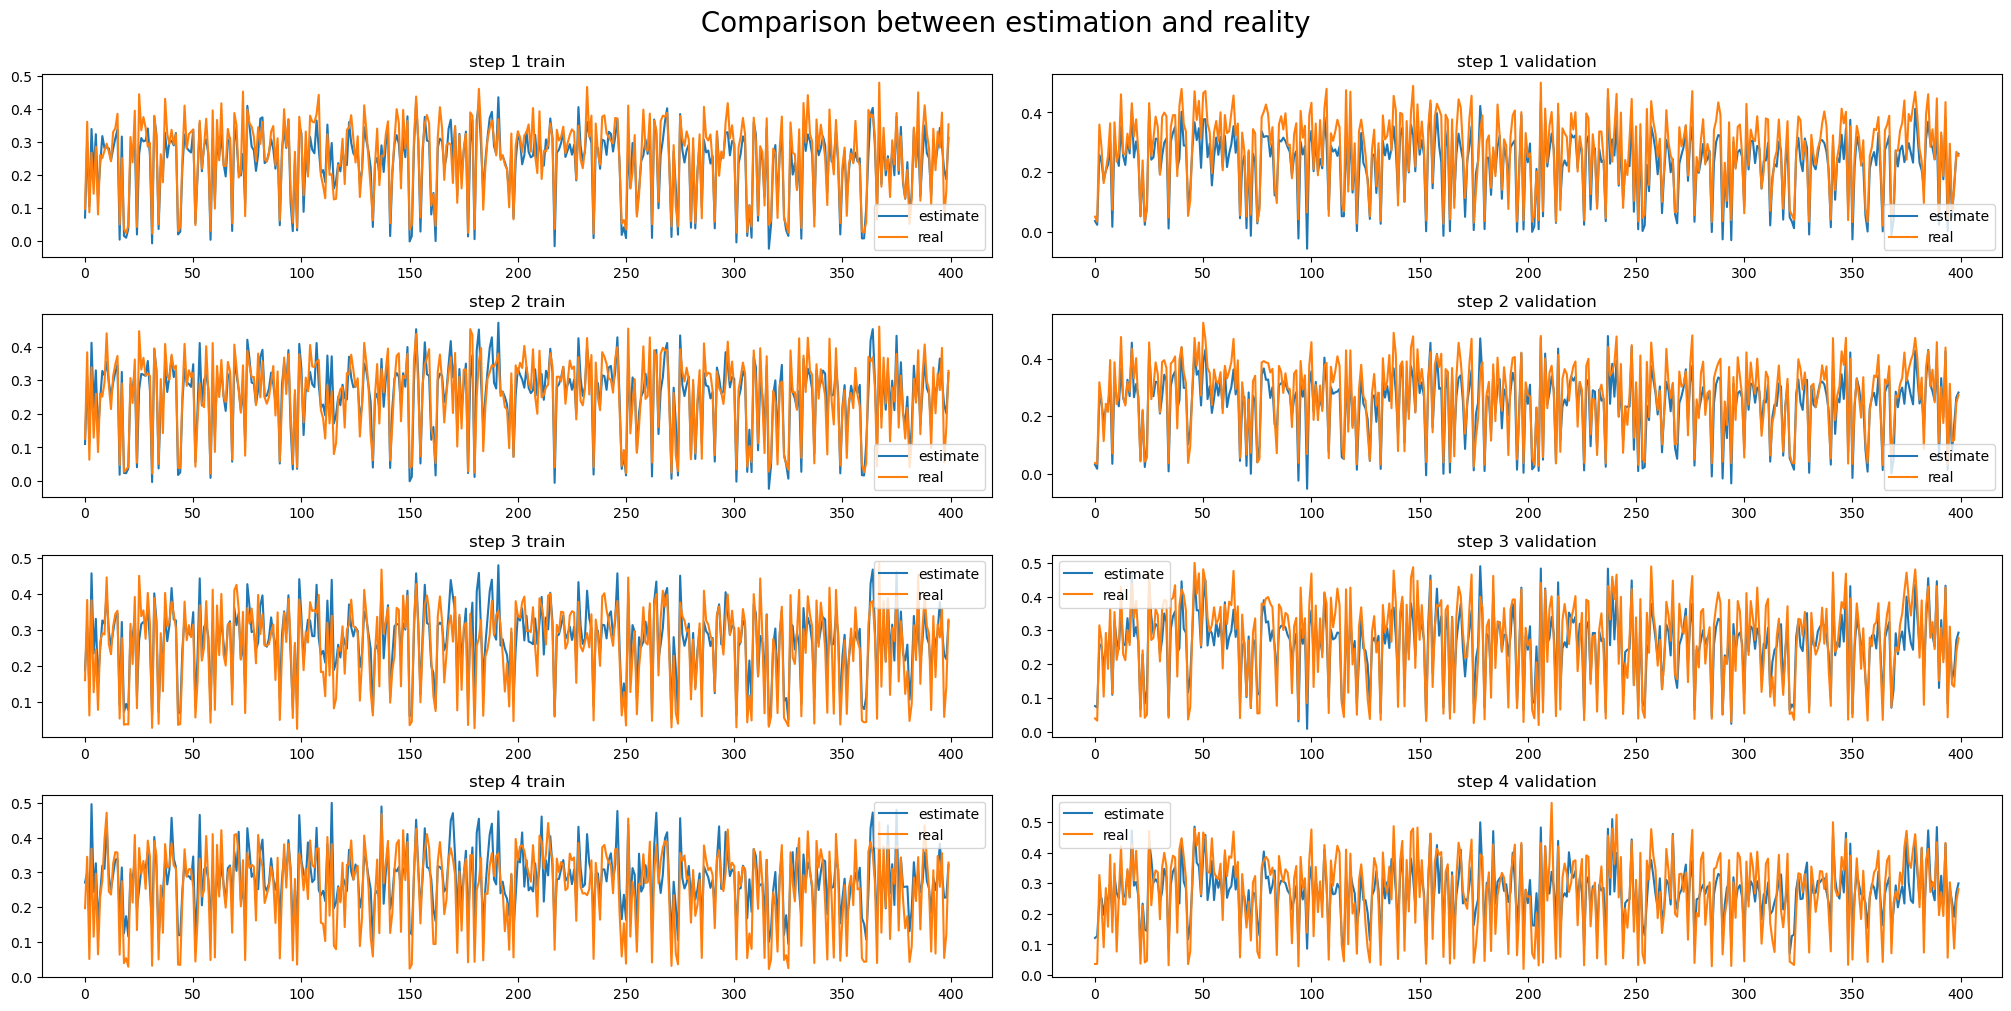

In [20]:
plot(model,
     config,
     loss_training, 
     loss_validation, 
     "GLSTM", 
     show = True)